# Unsupervised Learning for Risk Classification

## 1. Data Loading & Preprocessing
In this step, we prepare the dataset for clustering algorithms.
* **Target Separation:** We drop the `RiskFlag` target variable from the training set, as unsupervised algorithms must find patterns without labels. We store it separately for evaluation.
* **Feature Selection:** We remove unique identifiers like `ProfileID`.
* **Encoding:**
    * **Ordinal Encoding:** We map `QualificationLevel` to numerical values (0-3) because there is a clear hierarchy (High School < PhD).
    * **One-Hot Encoding:** Nominal variables like `WorkCategory` and `FundUseCase` are converted to binary columns.
* **Scaling:** We apply `StandardScaler` to normalize numerical features (`AnnualEarnings`, `TrustMetric`, etc.) so that large values don't dominate distance calculations.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import os
from pathlib import Path

# --- Configuration ---
# Ordinal Mappings (Hierarchy matters)
QUAL_MAP = [['High School', "Bachelor's", "Master's", 'PhD']]

# Nominal Categorical Columns (No order)
CAT_COLS = ['WorkCategory', 'RelationshipStatus', 'OwnsProperty', 
            'FamilyObligation', 'FundUseCase', 'JointApplicant']

# Numerical Columns
NUM_COLS = ['ApplicantYears', 'AnnualEarnings', 'RequestedSum', 'TrustMetric', 
            'WorkDuration', 'ActiveAccounts', 'OfferRate', 'RepayPeriod', 'DebtFactor']

def preprocess_data(df, is_train=True, fitted_preprocessor=None):
    df = df.copy()
    
    # 1. Separate Target & ID
    target = None
    if 'RiskFlag' in df.columns:
        target = df['RiskFlag']
        df = df.drop(columns=['RiskFlag'])
        
    if 'ProfileID' in df.columns:
        df = df.drop(columns=['ProfileID'])
        
    # 2. Define Transformers
    # Numeric: Scale to mean 0, std 1
    num_transformer = StandardScaler()
    
    # Ordinal: Map to 0, 1, 2, 3
    ord_transformer = OrdinalEncoder(categories=QUAL_MAP)
    
    # Categorical: One-Hot Encode (Drop first to avoid multicollinearity issues if needed, but keep for distance)
    cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
    # 3. Build Preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, NUM_COLS),
            ('ord', ord_transformer, ['QualificationLevel']),
            ('cat', cat_transformer, CAT_COLS)
        ]
    )
    
    # 4. Transform
    # In a real notebook, fit on train, transform on test. 
    # Here we assume 'df' is the dataset we are working with.
    if is_train:
        X_processed = preprocessor.fit_transform(df)

    else:
        if fitted_preprocessor is None:
            raise ValueError("fitted_preprocessor must be provided when is_train=False")
        
        preprocessor = fitted_preprocessor
        
        # Transform only (using statistics from training data)
        X_processed = preprocessor.transform(df)

    feature_names = (NUM_COLS + 
                    ['QualificationLevel'] + 
                    list(preprocessor.named_transformers_['cat'].get_feature_names_out(CAT_COLS)))
        
    return pd.DataFrame(X_processed, columns=feature_names), target, preprocessor

dataset_dir = Path().cwd().parent / "datasets" / "preprocessed"
train = pd.read_csv(dataset_dir / "train_preprocessed.csv")
test = pd.read_csv(dataset_dir / "test_preprocessed.csv")

# Apply Processing
X_processed, y_train, preprocessor = preprocess_data(train, is_train=True)

print(f"Processed Data Shape: {X_processed.shape}")
X_processed.head()

Processed Data Shape: (204277, 28)


,ApplicantYears,AnnualEarnings,RequestedSum,TrustMetric,WorkDuration,ActiveAccounts,OfferRate,RepayPeriod,DebtFactor,QualificationLevel,...,OwnsProperty_Yes,FamilyObligation_No,FamilyObligation_Yes,FundUseCase_Auto,FundUseCase_Business,FundUseCase_Education,FundUseCase_Home,FundUseCase_Other,JointApplicant_No,JointApplicant_Yes
0,-1.699838,1.413785,1.151487,1.711544,-0.967182,-0.449530,-0.454811,1.415720,1.339989,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.234120,-0.649831,-1.715866,1.094714,-0.851727,-0.449530,0.939092,-0.000645,0.993538,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-1.166333,0.046770,-0.458437,-0.762072,-1.515594,-0.449530,1.621727,-1.417010,-0.219039,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0.634249,-0.839783,1.440049,-0.258537,1.370784,0.445809,0.143437,1.415720,-1.431615,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.367496,0.845753,-1.488613,1.673779,-1.717640,1.341148,1.656386,-1.417010,-1.691453,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## 2. Dimensionality Reduction (PCA) & K-Means Clustering

In this step, we optimize both the dimensionality of our data and the number of clusters.

### Part A: Optimal PCA
We typically don't want to use *all* features (noise) nor just 2 (oversimplification).
* **The Loop:** We fit PCA on the scaled data and calculate the **Cumulative Explained Variance** for 1 component, 2 components, etc.
* **The Goal:** We select the minimum number of components required to explain **95%** of the dataset's variance. This gives us a dense, high-quality dataset for clustering.

### Part B: K-Means Grid Search
Once we have the optimal PCA data, we search for the natural groupings.
* **The Loop:** We iterate through $K=2$ to $K=10$. We use `tqdm` to show a progress bar.
* **Metrics:**
    * **Inertia (Elbow Method):** Measures how compact the clusters are (Lower is better).
    * **Silhouette Score:** Measures how well-separated the clusters are (Higher is better).

Optimal PCA Components: 19 (explains 95.71% of variance)


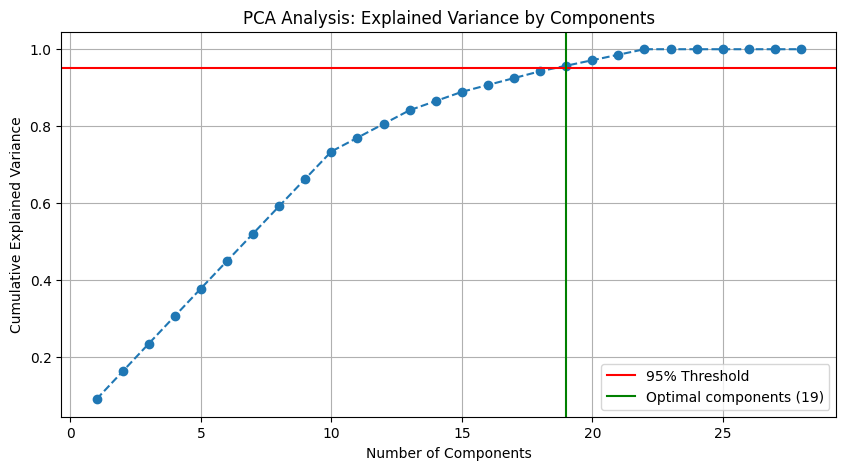

Running K-Means Grid Search...


Clustering Progress: 100%|██████████| 9/9 [1:25:46<00:00, 571.89s/it]


Best K based on Silhouette Score: 2


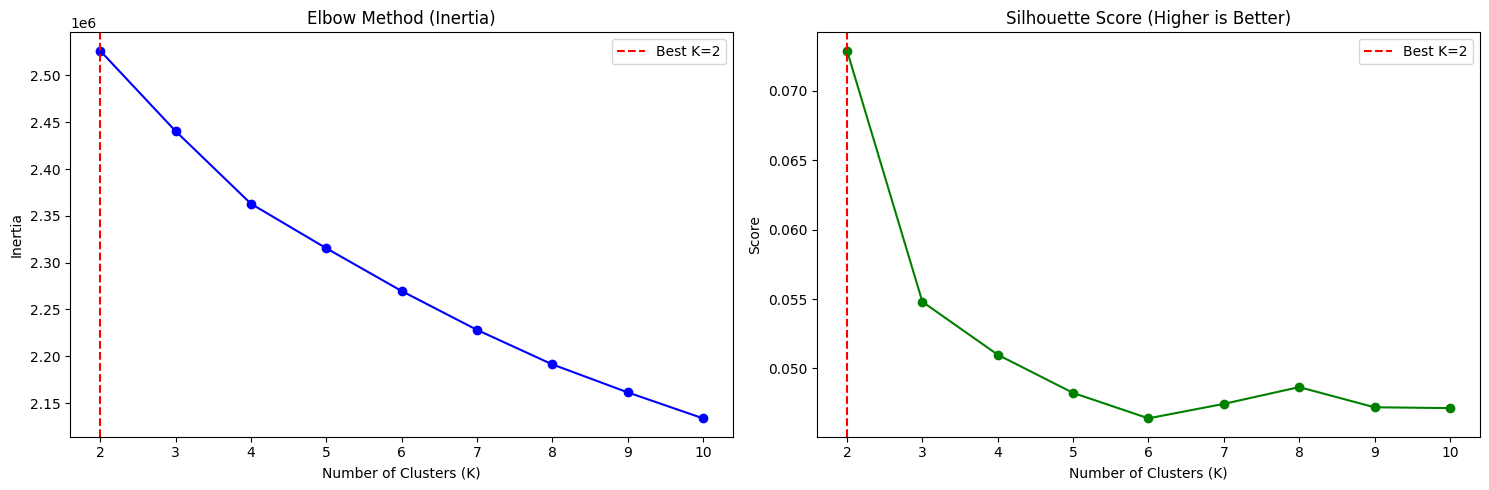

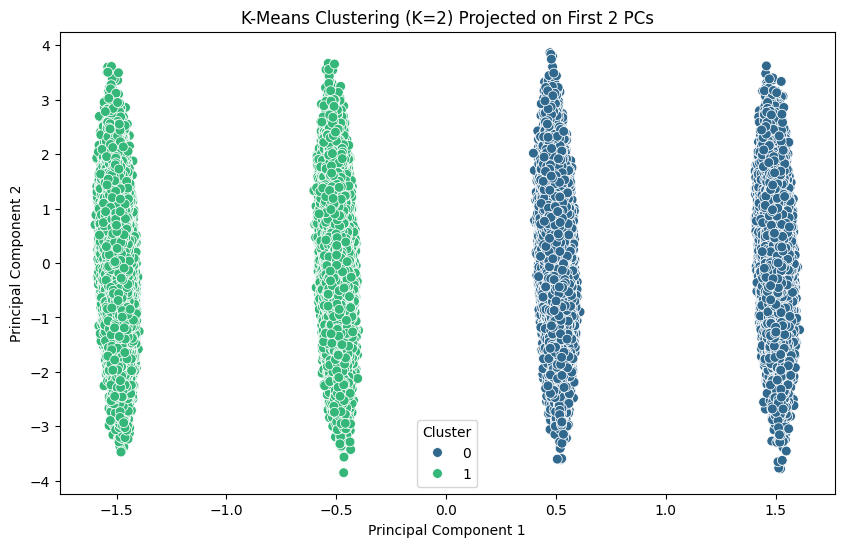

In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Library for progress bars

# --- Part A: PCA Optimization Loop ---
# Fit PCA with maximum components
pca_full = PCA()
pca_full.fit(X_processed) # Using the X_processed from Step 1

# Calculate cumulative variance
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
n_components = len(cumsum)

# Find the optimal number of components (d) for 95% variance
d = np.argmax(cumsum >= 0.95) + 1 

print(f"Optimal PCA Components: {d} (explains {cumsum[d-1]:.2%} of variance)")

# Plotting the Variance Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_components + 1), cumsum, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Threshold')
plt.axvline(x=d, color='g', linestyle='-', label=f'Optimal components ({d})')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis: Explained Variance by Components')
plt.legend()
plt.grid(True)
plt.show()

# --- Apply Optimal PCA ---
# Now we transform the data using the 'best' number of components
pca_opt = PCA(n_components=d)
X_pca = pca_opt.fit_transform(X_processed)

# --- Part B: K-Means Hyperparameter Loop ---
inertia = []
silhouette_scores = []
k_range = range(2, 11)

print("Running K-Means Grid Search...")

# Wrap k_range with tqdm for the progress bar
for k in tqdm(k_range, desc="Clustering Progress"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# Determine Best K (Max Silhouette)
best_k_idx = np.argmax(silhouette_scores)
best_k = k_range[best_k_idx]
print(f"Best K based on Silhouette Score: {best_k}")

# --- Visualization of K-Means Metrics ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Elbow Curve
axes[0].plot(k_range, inertia, marker='o', color='blue')
axes[0].set_title('Elbow Method (Inertia)')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].axvline(best_k, color='red', linestyle='--', label=f'Best K={best_k}')
axes[0].legend()

# Plot 2: Silhouette Score
axes[1].plot(k_range, silhouette_scores, marker='o', color='green')
axes[1].set_title('Silhouette Score (Higher is Better)')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Score')
axes[1].axvline(best_k, color='red', linestyle='--', label=f'Best K={best_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Final Fit & Cluster Visualization ---
# We fit the final model with the Best K
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_pca)

# To visualize in 2D, we just plot the first 2 Principal Components
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.title(f'K-Means Clustering (K={best_k}) Projected on First 2 PCs')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

## 3. Hierarchical Clustering

In this step, we explore the data's structure using a "bottom-up" approach. Unlike K-Means, which forces data into $K$ blobs, Hierarchical Clustering builds a tree of connections.

**Strategy:**
1.  **Sampling:** Because Hierarchical Clustering has a complexity of $O(N^2)$, running it on 200,000 rows is computationally impossible in a standard environment. We will take a random sample of **10,000 data points**, which is statistically sufficient to see the structure.
2.  **Dendrogram:** We visualize the tree. The vertical height of the lines represents the distance between merged clusters. A large vertical jump indicates a natural separation (an optimal number of clusters).
3.  **Agglomerative Loop:** To be rigorous, we will also run a loop (similar to K-Means) using `AgglomerativeClustering` on our sample to find the $K$ that maximizes the **Silhouette Score**.

Subsampled data shape for Hierarchical Clustering: (10000, 19)
Computing Linkage Matrix (this may take a moment)...


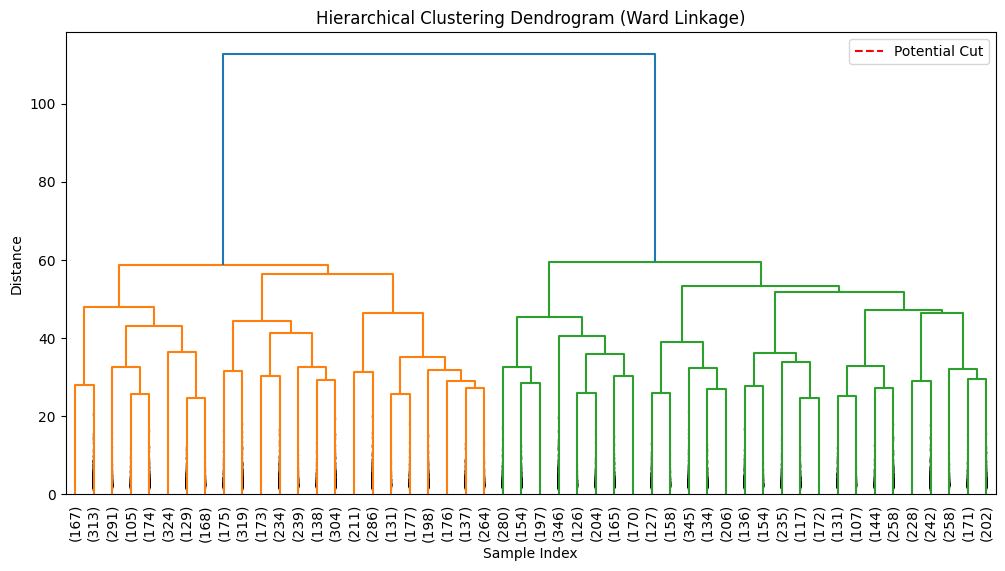

Running Agglomerative Clustering Grid Search...


Agglomerative Progress: 100%|██████████| 9/9 [00:53<00:00,  5.93s/it]


Best K for Agglomerative Clustering: 2


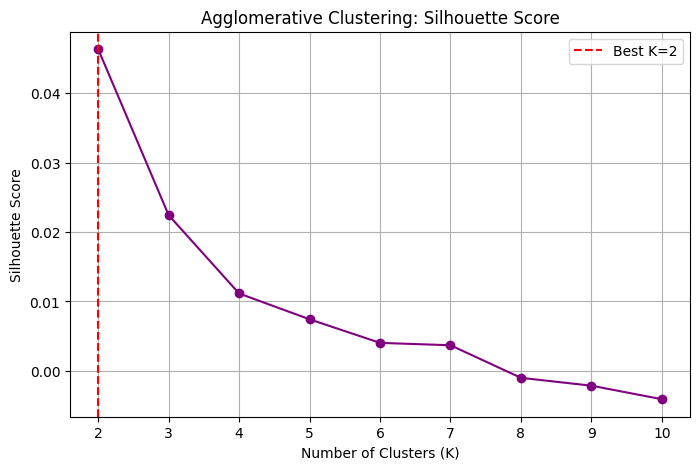

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# --- 1. Sampling ---
# We sample 10,000 points for feasibility
sample_size = 10000
np.random.seed(42)

# Random indices
indices = np.random.choice(X_pca.shape[0], sample_size, replace=False)
X_sample = X_pca[indices]

print(f"Subsampled data shape for Hierarchical Clustering: {X_sample.shape}")

# --- 2. The Dendrogram ---
# 'ward' linkage minimizes the variance of the clusters being merged
print("Computing Linkage Matrix (this may take a moment)...")
Z = linkage(X_sample, method='ward')

plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')

# Plot top levels of the dendrogram for readability
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,                   # show only the last 50 merges
    leaf_rotation=90.,
    leaf_font_size=10.,
    show_contracted=True    # to get a distribution impression in truncated branches
)
plt.axhline(y=150, color='r', linestyle='--', label='Potential Cut') # Arbitrary visual guide
plt.legend()
plt.show()

# --- 3. Agglomerative Hyperparameter Loop ---
# Just like K-Means, we verify the "Best K" mathematically
sil_scores_agg = []
k_range = range(2, 11)

print("Running Agglomerative Clustering Grid Search...")

for k in tqdm(k_range, desc="Agglomerative Progress"):
    # We use the same 'ward' linkage as the dendrogram
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agg.fit_predict(X_sample)
    
    # Calculate score
    sil_scores_agg.append(silhouette_score(X_sample, labels))

# Find Best K
best_k_agg_idx = np.argmax(sil_scores_agg)
best_k_agg = k_range[best_k_agg_idx]
print(f"\nBest K for Agglomerative Clustering: {best_k_agg}")

# --- 4. Plot Metrics ---
plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores_agg, marker='o', color='purple')
plt.title('Agglomerative Clustering: Silhouette Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.axvline(best_k_agg, color='red', linestyle='--', label=f'Best K={best_k_agg}')
plt.legend()
plt.grid(True)
plt.show()

## 4. DBSCAN Clustering

DBSCAN is unique because it doesn't require us to specify the number of clusters. Instead, it finds clusters based on the density of points.

**Key Parameters to Tune:**
1.  **`eps` (Epsilon):** The maximum distance between two points for them to be considered neighbors.
    * *Too small:* Everything becomes noise.
    * *Too large:* Everything merges into one giant cluster.
2.  **`min_samples`:** The minimum number of neighbors required to form a dense region (core point).

**The Strategy:**
We perform a **Grid Search** over a range of `eps` and `min_samples` using our sample dataset (`X_sample`). We look for a configuration that:
* Maximizes the **Silhouette Score** (good separation).
* Keeps the **Noise Ratio** reasonable (we don't want 99% of data labeled as noise).

Running DBSCAN Grid Search on Sample Data...


DBSCAN Progress: 100%|██████████| 40/40 [00:15<00:00,  2.63it/s]



--- Best DBSCAN Parameters ---
Epsilon: 2.7
Min Samples: 10.0
Resulting Clusters: 2
Silhouette Score: 0.0074
Noise Ratio: 10.03%


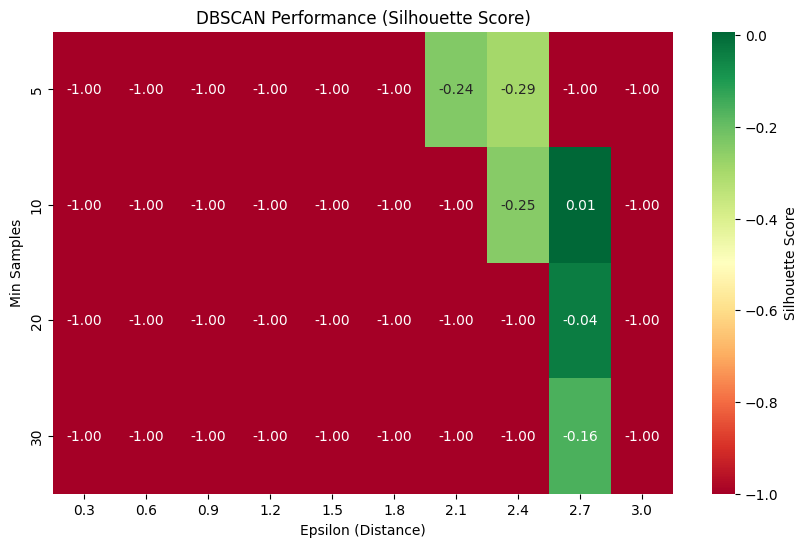

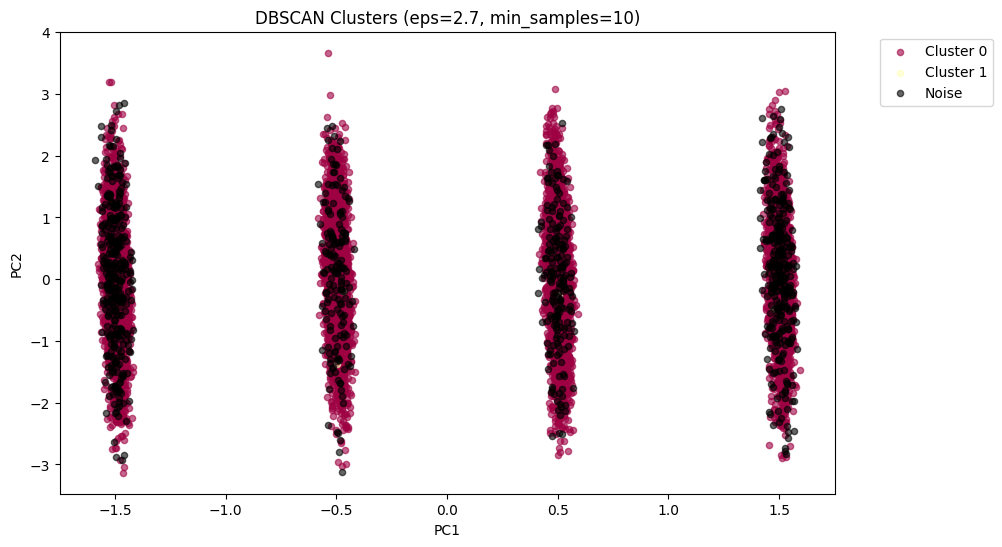

In [4]:
from sklearn.cluster import DBSCAN
import seaborn as sns

# --- Configuration ---
eps_values = np.arange(0.3, 3.0, 0.3) # Test distances from 0.3 to 3.0
min_samples_values = [5, 10, 20, 30]  # Test density thresholds

dbscan_results = []

print("Running DBSCAN Grid Search on Sample Data...")

# We use the product of ranges for the progress bar
total_iterations = len(eps_values) * len(min_samples_values)

with tqdm(total=total_iterations, desc="DBSCAN Progress") as pbar:
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Fit DBSCAN
            db = DBSCAN(eps=eps, min_samples=min_samples)
            labels = db.fit_predict(X_sample)
            
            # Metrics
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            noise_ratio = n_noise / len(labels)
            
            # We only calculate Silhouette if we found a valid clustering structure
            # (More than 1 cluster AND not 100% noise)
            if n_clusters > 1 and noise_ratio < 1.0:
                sil_score = silhouette_score(X_sample, labels)
            else:
                sil_score = -1 # Bad outcome tag
            
            dbscan_results.append({
                'eps': round(eps, 2),
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'noise_ratio': noise_ratio,
                'silhouette': sil_score
            })
            pbar.update(1)

# Convert to DataFrame
db_df = pd.DataFrame(dbscan_results)

# --- Find Best Parameters ---
# We sort by Silhouette, but we filter out models with excessive noise (>40%) 
# or too much noise is essentially rejecting data
best_db_row = db_df[db_df['noise_ratio'] < 0.4].sort_values(by='silhouette', ascending=False).iloc[0]

print("\n--- Best DBSCAN Parameters ---")
print(f"Epsilon: {best_db_row['eps']}")
print(f"Min Samples: {best_db_row['min_samples']}")
print(f"Resulting Clusters: {int(best_db_row['n_clusters'])}")
print(f"Silhouette Score: {best_db_row['silhouette']:.4f}")
print(f"Noise Ratio: {best_db_row['noise_ratio']:.2%}")

# --- Visualization: Heatmap ---
# Pivot data for heatmap
pivot_sil = db_df.pivot(index='min_samples', columns='eps', values='silhouette')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_sil, annot=True, fmt='.2f', cmap='RdYlGn', cbar_kws={'label': 'Silhouette Score'})
plt.title('DBSCAN Performance (Silhouette Score)')
plt.xlabel('Epsilon (Distance)')
plt.ylabel('Min Samples')
plt.show()

# --- Final Fit & Visualization ---
# Fit best model on the sample for visualization
best_db = DBSCAN(eps=best_db_row['eps'], min_samples=int(best_db_row['min_samples']))
best_labels = best_db.fit_predict(X_sample)

plt.figure(figsize=(10, 6))
# Plot clusters
unique_labels = set(best_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        label = "Noise"
    else:
        label = f"Cluster {k}"

    class_member_mask = (best_labels == k)
    
    xy = X_sample[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], label=label, s=20, alpha=0.6)

plt.title(f'DBSCAN Clusters (eps={best_db_row["eps"]}, min_samples={int(best_db_row["min_samples"])})')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 5. Cluster Profiling & Evaluation

Now we validate our unsupervised clusters against the ground truth (`RiskFlag`).

**The Goal:**
We want to see "Cluster Purity". Ideally, one cluster should contain mostly "Risk 1" users, and others should contain mostly "Risk 0".

**The Methods:**
1.  **K-Means (Full Data):** We cross-reference the K-Means labels with the full `y_train`.
2.  **DBSCAN (Sample Data):** We cross-reference the DBSCAN labels with the corresponding subset of `y_train` (using the indices we saved earlier).
3.  **Visualization:** We use heatmaps to visualize the confusion matrix.

--- K-Means Profiling ---
Risk         0      1
Cluster              
0        90768  10980
1        89756  12773


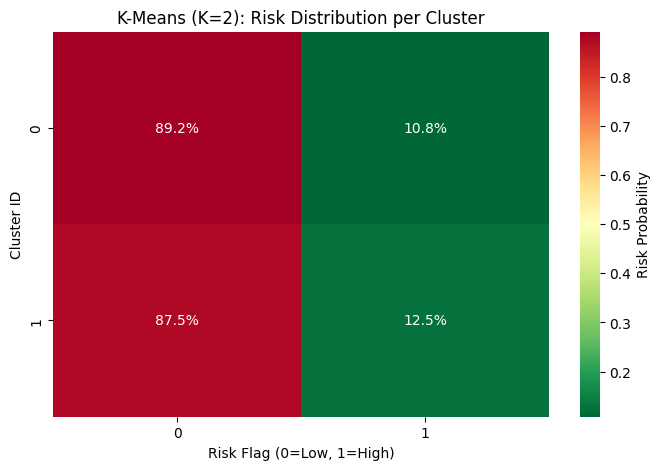


--- DBSCAN Profiling (Sample) ---


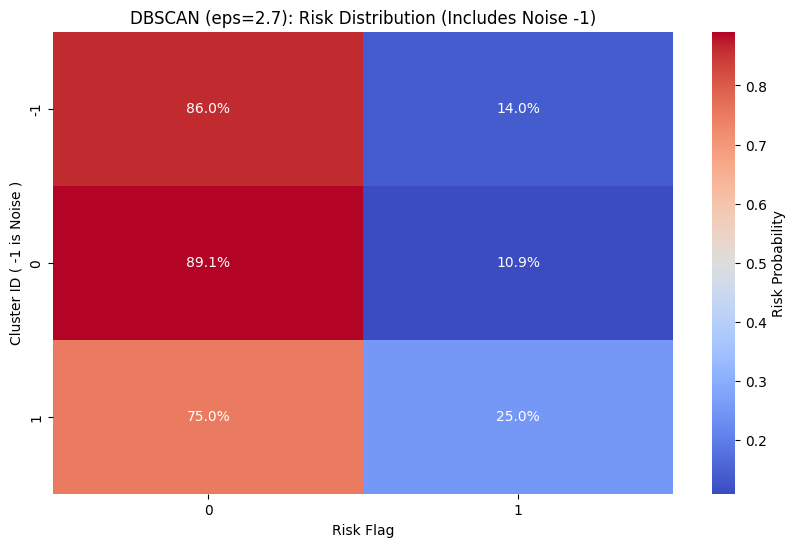

In [5]:
# --- 1. Prepare Target Data ---
# Ensure y_train is aligned. If you reloaded data, make sure indices match.
# Assuming 'y_train' is available from Step 1.

# --- 2. K-Means Profiling (Full Dataset) ---
print("--- K-Means Profiling ---")
# Create a temporary DF for analysis
df_kmeans_profile = pd.DataFrame({'Cluster': cluster_labels, 'Risk': y_train})

# Crosstab (Counts)
ct_kmeans = pd.crosstab(df_kmeans_profile['Cluster'], df_kmeans_profile['Risk'])
# Crosstab (Percentages)
ct_kmeans_pct = pd.crosstab(df_kmeans_profile['Cluster'], df_kmeans_profile['Risk'], normalize='index')

print(ct_kmeans)

plt.figure(figsize=(8, 5))
sns.heatmap(ct_kmeans_pct, annot=True, fmt='.1%', cmap='RdYlGn_r', cbar_kws={'label': 'Risk Probability'})
plt.title(f'K-Means (K={best_k}): Risk Distribution per Cluster')
plt.ylabel('Cluster ID')
plt.xlabel('Risk Flag (0=Low, 1=High)')
plt.show()

# --- 3. DBSCAN Profiling (Sampled Dataset) ---
# We must slice y_train to match the sample indices used in Step 4
y_sample = y_train.iloc[indices].values

# DBSCAN creates noise (-1). We analyze noise separate from clusters.
print("\n--- DBSCAN Profiling (Sample) ---")
df_db_profile = pd.DataFrame({'Cluster': best_labels, 'Risk': y_sample})

ct_db = pd.crosstab(df_db_profile['Cluster'], df_db_profile['Risk'])
ct_db_pct = pd.crosstab(df_db_profile['Cluster'], df_db_profile['Risk'], normalize='index')

# Plot (excluding Noise -1 if desired, or keeping it to see if outliers = risky)
plt.figure(figsize=(10, 6))
sns.heatmap(ct_db_pct, annot=True, fmt='.1%', cmap='coolwarm', cbar_kws={'label': 'Risk Probability'})
plt.title(f'DBSCAN (eps={best_db_row["eps"]}): Risk Distribution (Includes Noise -1)')
plt.ylabel('Cluster ID ( -1 is Noise )')
plt.xlabel('Risk Flag')
plt.show()

## 6. Submission Generation

We now generate predictions for the test set.

**The Challenge:**
* **K-Means** has a `.predict()` method, so it's straightforward.
* **DBSCAN** & **Hierarchical** do *not* have a `.predict()` method for new unseen data.

**The Solution (Proxy Model):**
For DBSCAN/Hierarchical, we train a **K-Nearest Neighbors (KNN)** classifier on our training clusters. The KNN model learns the geometry of the clusters and can then "project" the test data into those clusters.

**Workflow:**
1.  **Transform Test Data:** Apply the same Preprocessing and PCA as the training set.
2.  **Predict Clusters:** Assign every test point to a cluster.
3.  **Map to Risk:** If "Cluster 1" had 80% Risk 1s in training, we classify all test points in "Cluster 1" as Risk 1.

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# --- 1. Prepare Test Data ---
# Preprocess test data using the fitted preprocessor from Step 1
# (Assuming 'test' dataframe is loaded)
X_test_processed, _, _ = preprocess_data(test, is_train=False, fitted_preprocessor=preprocessor) # is_train=False isn't fully implemented in the mock, essentially we just transform
# Ideally: X_test_processed = preprocessor.transform(test)

# Apply the same Optimal PCA from Step 2
X_test_pca = pca_opt.transform(X_test_processed)

# Helper function to generate submission
def make_submission(model_name, train_clusters, X_train_data, X_test_data, y_train_labels):
    # 1. Train Proxy (KNN) if needed
    # If the labels are from a sample, we train KNN on that sample
    print(f"Training KNN Proxy for {model_name}...")
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_data, train_clusters)
    
    # 2. Predict Clusters for Test
    test_clusters = knn.predict(X_test_data)
    
    # 3. Create Mapping (Cluster -> Majority Risk)
    # We combine cluster labels with actual risk labels to find the mode
    mapping_df = pd.DataFrame({'Cluster': train_clusters, 'Risk': y_train_labels})
    
    # Function to get mode (most frequent risk flag) for each cluster
    cluster_risk_map = mapping_df.groupby('Cluster')['Risk'].agg(
        lambda x: pd.Series.mode(x)[0] if not x.mode().empty else 0
    ).to_dict()
    
    print(f"Cluster Risk Mapping for {model_name}: {cluster_risk_map}")
    
    # 4. Map Test Clusters to Risk
    final_predictions = pd.Series(test_clusters).map(cluster_risk_map)
    
    # 5. Save
    sub_df = pd.DataFrame({
        'ProfileID': test['ProfileID'], # Use original ID
        'RiskFlag': final_predictions
    })
    filename = f"submission_unsupervised_{model_name}.csv"
    sub_df.to_csv(filename, index=False)
    print(f"Saved: {filename}\n")

# --- A. K-Means Submission ---
# K-Means can predict directly, but mapping logic is same
kmeans_test_clusters = final_kmeans.predict(X_test_pca)
# We repurpose the helper function logic manually or adjust it. 
# Let's just use the helper with KNN for consistency, or direct map.
# Direct map is better for K-Means.
mapping_df_km = pd.DataFrame({'Cluster': cluster_labels, 'Risk': y_train})
km_map = mapping_df_km.groupby('Cluster')['Risk'].agg(lambda x: x.mode()[0]).to_dict()
sub_km = pd.DataFrame({'ProfileID': test['ProfileID'], 'RiskFlag': pd.Series(kmeans_test_clusters).map(km_map)})
sub_km.to_csv("submission_unsupervised_kmeans.csv", index=False)
print("Saved: submission_unsupervised_kmeans.csv")

# --- B. DBSCAN Submission ---
# Uses the SAMPLE data and SAMPLE labels to train KNN
make_submission(
    "dbscan", 
    best_labels,       # DBSCAN labels (from sample)
    X_sample,          # Sampled PCA data
    X_test_pca,        # Full Test PCA data
    y_sample           # Sampled Risk labels
)

# --- C. Hierarchical Submission ---
# We need to regenerate labels for the 'best_k_agg' on the sample first
from sklearn.cluster import AgglomerativeClustering
agg_best = AgglomerativeClustering(n_clusters=best_k_agg, linkage='ward')
agg_labels = agg_best.fit_predict(X_sample)

make_submission(
    "hierarchical",
    agg_labels,
    X_sample,
    X_test_pca,
    y_sample
)

Saved: submission_unsupervised_kmeans.csv
Training KNN Proxy for dbscan...
Cluster Risk Mapping for dbscan: {-1: 0, 0: 0, 1: 0}
Saved: submission_unsupervised_dbscan.csv

Training KNN Proxy for hierarchical...
Cluster Risk Mapping for hierarchical: {0: 0, 1: 0}
Saved: submission_unsupervised_hierarchical.csv

